### Redes Neurais Artificiais
### Professor Ciniro Nametala - IFMG

## Previsão em séries temporais com Redes Neurais Recorrentes - Células LSTM

Neste trabalho vamos utilizar o *dataset Air Passenger* disponível no [repositório de datasets do Kaggle](https://www.kaggle.com/datasets/rakannimer/air-passengers). O conjunto de dados "Airline Passengers" contém informações mensais sobre o número de passageiros de companhias aéreas ao longo de um período de tempo. Ele geralmente é usado para fins de previsão, onde os modelos de *machine learning* são treinados para prever a demanda futura de passageiros com base nos padrões históricos.

A origem específica desse conjunto de dados remonta à década de 1940 e foi publicado originalmente por Box e Jenkins em seu livro *Time Series Analysis: Forecasting and Control* em 1976. Os dados representam o número mensal de passageiros de uma companhia aérea internacional entre os anos de 1949 e 1960.

Esse conjunto de dados é popular entre os praticantes de *machine learning* devido à sua natureza temporal e à presença de tendências sazonais, tornando-o adequado para a aplicação e teste de algoritmos de previsão. O *dataset* possui 143 valores e duas colunas:
1. Mês
2. Quantidade de passageiros

Opcionalmente você pode também comentar e descomentar partes do código a seguir para usar a série temporal de preço de fechamento diário da ação do Banco do Brasil (BBAS3) no período entre 02/01/2009 e 04/11/2013. Os valores foram retirados da ferramenta MetaTrader. Neste caso, o *dataset* possui as colunas:
1. Data
2. Abertura
3. Máximo
4. Mínimo
5. Fechamento
6. Volume

## 1. Preparação do ambiente

### 1.1 Configurações de ambiente

In [1]:
#funcao para deixar o jupyter com celulas preenchendo toda a tela
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#cria a pasta para armazenar o checkpoint e os modelos treinados
import os
os.makedirs("models", exist_ok=True)

### 1.2 Importação de pacotes

In [3]:
#para exportar o requeriments
import subprocess
import sys

#bibliotecas para trabalhar com dados e graficos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

#bibliotecas do scikit-learn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

#biblioteca para exportacoes e importacoes de arquivos
from joblib import dump, load

#utilitario de GPU para Windows
#from numba import cuda

#biblioteca para implementar uma barra de progresso
import progressbar

#biblioteca para tocar sons
import pygame

#bibliotecas para deep learning
import tensorflow.keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, GRU, Bidirectional, Dense

from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#bibliotecas para plotar graficos do keras
import pydot as pyd
from tensorflow.keras.utils import plot_model, model_to_dot
tensorflow.keras.utils.pydot = pyd

/opt/anaconda3/envs/dl_tf/lib/python3.11/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


pygame 2.6.1 (SDL 2.28.4, Python 3.11.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


### 1.3 Verificando versões

In [4]:
import sys
print(f"Python version: {sys.version}")

import numpy as np
print(f"NumPy version: {np.__version__}")

import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

import pandas as pd
print(f"Pandas version: {pd.__version__}")

import matplotlib
print(f"Matplotlib version: {matplotlib.__version__}")

import seaborn as sns
print(f"Seaborn version: {sns.__version__}")

Python version: 3.11.0 | packaged by conda-forge | (main, Jan 14 2023, 12:26:40) [Clang 14.0.6 ]
NumPy version: 1.26.4
TensorFlow version: 2.15.0
Pandas version: 2.3.3
Matplotlib version: 3.10.7
Seaborn version: 0.13.2


### 1.4 Checagem de GPU

In [5]:
# Verificação de GPU (sem warning)
gpus = tf.config.list_physical_devices('GPU')
print(f"TensorFlow encontrou GPUs: {len(gpus) > 0}")
print(f"Dispositivos GPU TensorFlow: {gpus}")

TensorFlow encontrou GPUs: True
Dispositivos GPU TensorFlow: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 1.5 Escolha do dataset

In [6]:
use_dataset = 'AP' #AP para AirPassenger ou BB para Banco do Brasil
new_model = True   #gerar um novo modelo ou usar um pronto?

## 2. Importações de dados

### 2.1 Opção a) Air Passenger

In [7]:
if (use_dataset == 'AP'):
    col_names = ['mes', 'passageiros']

    # importação de dados
    data = pd.read_csv('dataset/airline-passengers.csv', header=0, names=col_names)

    # converte tudo para número
    data['passageiros'] = data['passageiros'].astype("float32")

    x_names = 'passageiros'

    data

In [8]:
if (use_dataset == 'AP'):
    #ajustando o dataset para treinamento com o keras
    serie = data['passageiros'].values.reshape(-1, 1)

    print(serie.shape)

(144, 1)


### 2.2 Opção b) Banco do Brasil S.A.

In [9]:
if (use_dataset == 'BB'):
    col_names = ['data','abertura','maximo','minimo','fechamento','volume']

    # importação de dados
    data = pd.read_csv('dataset/bbas3.csv', header=0, names=col_names, sep=';')

    #remove as colunas nao usadas
    data = data.drop('abertura', axis=1)
    data = data.drop('maximo', axis=1)
    data = data.drop('minimo', axis=1)
    data = data.drop('volume', axis=1)

    # converte tudo para número
    data['fechamento'] = data['fechamento'].astype("float32")

    x_names = 'fechamento'

    #ajustando o dataset para treinamento com o keras
    serie = data['fechamento'].values.reshape(-1, 1)

    print(serie.shape)

## 3. Configurações do experimento

In [10]:
#parametros
norm_method = 'asinh' #log, asinh
range_adjust = (0,1)

if (use_dataset == 'AP'):
    #AIR PASSENGERS-------
    size_hist_window = 12 
    size_forw_window = 1
    model_name = 'dnn_air_pass.h5'

if (use_dataset == 'BB'):
    #BANCO DO BRASIL------
    size_hist_window = 20 
    size_forw_window = 10
    model_name = 'dnn_bbas3.h5'

#realizar ajuste dos dados
data_adjust_exec = True

#exportar os datasets tratados
export_frames = True

## 4. Análise de dados

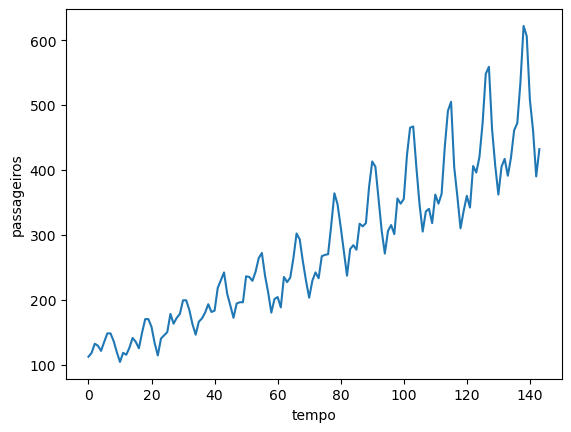

In [11]:
plt.plot(serie)
plt.xlabel("tempo")
plt.ylabel(x_names)
plt.show()

### 4.1 Sumarização estatística

In [12]:
def sumarizacao(serie, column):
    stats = []

    maximum = round(np.max(serie), 2)
    minimum = round(np.min(serie), 2)
    mean = round(np.mean(serie), 2)
    median = round(np.median(serie), 2)
    std = round(np.std(serie), 2)
    stats.append([column, maximum, minimum, mean, median, std])

    headers = ['Coluna', 'Máximo', 'Mínimo', 'Média', 'Mediana', 'Desvio Padrão']

    table = tabulate(stats, headers, tablefmt="pipe")
    print(table)

In [13]:
sumarizacao(serie, x_names)

| Coluna      |   Máximo |   Mínimo |   Média |   Mediana |   Desvio Padrão |
|:------------|---------:|---------:|--------:|----------:|----------------:|
| passageiros |      622 |      104 |   280.3 |     265.5 |          119.55 |


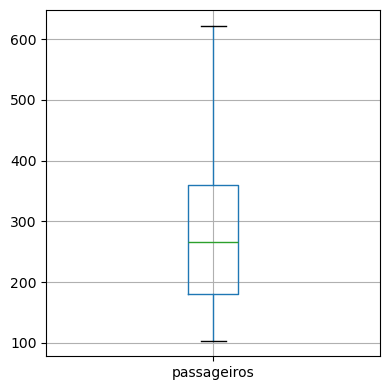

In [14]:
data.boxplot(column=x_names, figsize=(4, 4))
plt.tight_layout()
plt.show()

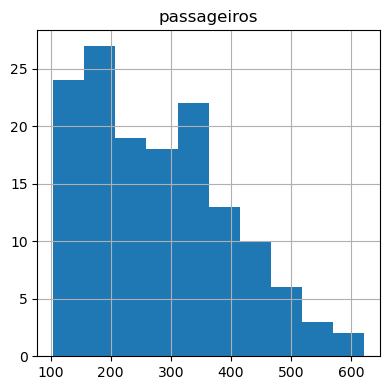

In [15]:
data.hist(column=x_names, figsize=(4, 4))
plt.tight_layout()
plt.show()

### 4.2 Verificando integridade dos dados

In [16]:
missing_counts = data.isnull().sum()
print("Total de dados faltantes por atributo:")
print(missing_counts)

Total de dados faltantes por atributo:
mes            0
passageiros    0
dtype: int64


### 4.3 Aplicando normalizacao e escala [0, 1]

In [17]:
def varianceEstabilization(serie, method):
    if method == 'asinh':
        return np.arcsinh(serie)
    elif method == 'log':
        return np.log(serie)
    else:
        return serie
    
def inverseVarianceEstabilization(serie, method):
    if method == 'asinh':
        return np.sinh(serie)
    elif method == 'log':
        return np.exp(serie)
    else:
        return serie

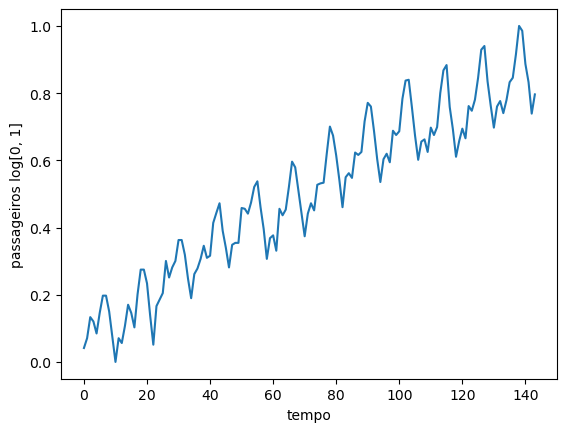

In [18]:
#ajuste de dados
if data_adjust_exec:
    serie = varianceEstabilization(serie, norm_method)
    scaler = MinMaxScaler(feature_range=range_adjust)
    serie = scaler.fit_transform(serie)
    
plt.plot(serie)
plt.xlabel("tempo")
plt.ylabel(x_names + " log[0, 1]")
plt.show()

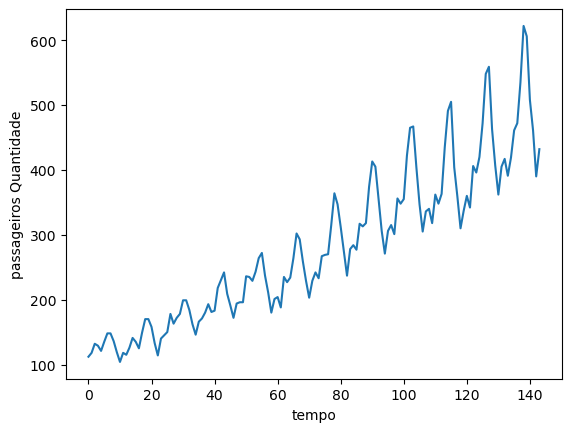

In [19]:
#desconversao de dados
serie_original = scaler.inverse_transform(serie)
serie_original = inverseVarianceEstabilization(serie_original, norm_method)

plt.plot(serie_original)
plt.xlabel("tempo")
plt.ylabel(x_names + " Quantidade")
plt.show()

## 5. Separacao dos conjuntos de dados (treino/validação e teste)

In [20]:
#separa os conjuntos de treino/validacao e teste
trainval_size = int(len(serie) * 0.70)
test_size = len(serie) - trainval_size
trainval, test = serie[0:trainval_size,:], serie[trainval_size:len(serie),:]

print(trainval.shape)
print(test.shape)

(100, 1)
(44, 1)


### 5.1 Criação das janelas móveis

In [21]:
#cria os frames com base numa janela historica de dados
def create_frames(serie, back_window_size, forw_window_size):
    x_frames, y_frames = [], []
    
    for i in range(0, len(serie) - back_window_size - 1, forw_window_size):
        x_frames.append(serie[i:(i + back_window_size), 0])
        y_frames.append(serie[(i + back_window_size):(i + back_window_size) + forw_window_size, 0])
        
    return np.array(x_frames), np.array(y_frames)

In [22]:
#cria os frames
x_trainval, y_trainval = create_frames(trainval, size_hist_window, size_forw_window)
x_test, y_test = create_frames(test, size_hist_window, size_forw_window)

print(x_trainval.shape)
print(y_trainval.shape)
print(x_test.shape)
print(y_test.shape)

(87, 12)
(87, 1)
(31, 12)
(31, 1)


In [23]:
serie[0:13]

array([[0.04143333],
       [0.07061028],
       [0.1332953 ],
       [0.12044191],
       [0.08464718],
       [0.14585996],
       [0.19726276],
       [0.19726276],
       [0.14998603],
       [0.07532835],
       [0.        ],
       [0.07061028],
       [0.05621219]], dtype=float32)

In [24]:
x_trainval[0:3]

array([[0.04143333, 0.07061028, 0.1332953 , 0.12044191, 0.08464718,
        0.14585996, 0.19726276, 0.19726276, 0.14998603, 0.07532835,
        0.        , 0.07061028],
       [0.07061028, 0.1332953 , 0.12044191, 0.08464718, 0.14585996,
        0.19726276, 0.19726276, 0.14998603, 0.07532835, 0.        ,
        0.07061028, 0.05621219],
       [0.1332953 , 0.12044191, 0.08464718, 0.14585996, 0.19726276,
        0.19726276, 0.14998603, 0.07532835, 0.        , 0.07061028,
        0.05621219, 0.10728574]], dtype=float32)

In [25]:
y_trainval[0:3]

array([[0.05621219],
       [0.10728574],
       [0.17017269]], dtype=float32)

In [26]:
#ajustando para atender aos requisitos de entrada da LSTM: (amostras, timesteps, features)
x_trainval = np.expand_dims(x_trainval, axis=2)
y_trainval = np.expand_dims(y_trainval, axis=2)
x_test = np.expand_dims(x_test, axis=2)
y_test = np.expand_dims(y_test, axis=2)

print(x_trainval.shape)
print(y_trainval.shape)
print(x_test.shape)
print(y_test.shape)

(87, 12, 1)
(87, 1, 1)
(31, 12, 1)
(31, 1, 1)


## 6. Treinamento do modelo

### 6.1 Construção do modelo

In [27]:
#-----------------
#CRIAÇÃO DO MODELO BASEADO EM LSTM
#-----------------

# Configurações de neurônios
units_lstm1 = 16
units_lstm2 = 32
units_lstm3 = 32
units_dense = 16

# Funções de ativação
actfunc_lstm1 = 'tanh'
actfunc_lstm2 = 'tanh'
actfunc_lstm3 = 'tanh'
actfunc_dense = 'tanh'
actfunc_output = 'tanh'

#inicializador
initializer = tensorflow.keras.initializers.LecunNormal(seed=42)

# Criação das entradas de treino+validação
inputs = Input(shape=(x_trainval.shape[1], x_trainval.shape[2]), name="x_train")

# Camada LSTM 1
layer_lstm1 = LSTM(units_lstm1, 
                    activation=actfunc_lstm1, 
                    return_sequences=True,
                    kernel_initializer=initializer)(inputs)

# Camada LSTM 2
layer_lstm2 = LSTM(units_lstm2, 
                    activation=actfunc_lstm2, 
                    return_sequences=True,
                    kernel_initializer=initializer)(layer_lstm1)

# Camada LSTM 3
layer_lstm3 = Bidirectional(LSTM(units_lstm3, 
                                activation=actfunc_lstm3, 
                                return_sequences=False,
                                kernel_initializer=initializer))(layer_lstm2)

# Camada densa final para ajustar o formato da saída
layer_dense = Dense(units_dense, activation=actfunc_dense)(layer_lstm3)

# Camada densa final para ajustar o formato da saída
layer_dense_out = Dense(y_trainval.shape[1], activation=actfunc_output)(layer_dense)

# Criação do modelo
model_trained = Model(inputs=inputs, outputs=layer_dense_out)

2025-12-11 16:45:55.945577: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-12-11 16:45:55.945603: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-12-11 16:45:55.945607: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-12-11 16:45:55.945630: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-11 16:45:55.945641: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### 6.2 Inspecionando o modelo

h = 1
h - 1 = 16
entrada no neuronio seguinte = (1 + 16) = 17
pesos entre a entrada e as celulas = 17 * 16 = 272
para cada neuronio adiciona o bias = 272 + 16 = 288
para cada portao = 288 * 4 = 1152

In [28]:
model_trained.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x_train (InputLayer)        [(None, 12, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 12, 16)            1152      
                                                                 
 lstm_1 (LSTM)               (None, 12, 32)            6272      
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                             

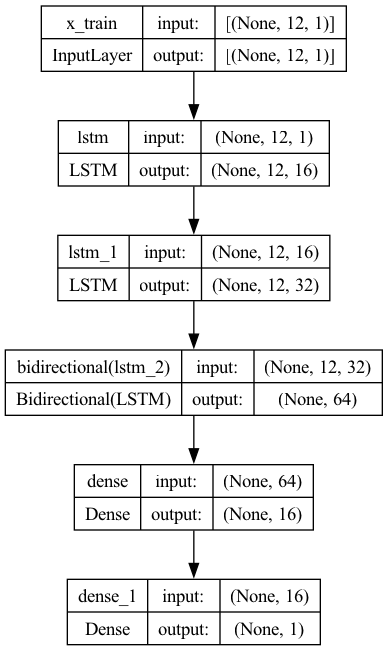

In [29]:
plot_model(model_trained, show_shapes=True, show_layer_names=True, rankdir="TB")  #TB para plotar na vertical

### 6.3 Otimização do modelo

In [30]:
if new_model:
    #com o AirPassenger não usa validacao
    if (use_dataset == 'AP'):
        cp = ModelCheckpoint(
            filepath='models/' + model_name + '_model_trained.weights.h5',
            save_weights_only=True,
            monitor='loss',
            mode='min',
            save_best_only=True
        )
        validation_size = 0.0

        es = EarlyStopping(monitor='loss', mode='min', patience=200)

    #com o Banco do Brasil usa validacao
    if (use_dataset == 'BB'):
        cp = ModelCheckpoint(
            filepath='models/' + model_name + '_model_trained.weights.h5',
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            save_best_only=True
        )
        validation_size = 0.2

        es = EarlyStopping(monitor='val_loss', mode='min', patience=200)

    
    opt = Adam(learning_rate=0.0001)
    model_trained.compile(optimizer=opt, loss='mean_squared_error')

    history = model_trained.fit(
        x_trainval,
        y_trainval,
        validation_split=validation_size,
        epochs=500,
        verbose=1,
        callbacks=[cp, es],
        batch_size=1,
        shuffle=False
    )

    np.save('models/' + model_name + '_history_model.npy', history.history)
    model_trained.load_weights('models/' + model_name + '_model_trained.weights.h5')
    model_trained.save('models/' + model_name + '.keras')
else:
    model_trained = load_model('models/' + model_name + '.keras')

Epoch 1/500


2025-12-11 16:45:57.847400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-12-11 16:45:57.933884: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


87/87 [==============================] - 3s 11ms/step - loss: 0.0314
Epoch 2/500
87/87 [==============================] - 1s 11ms/step - loss: 0.0140
Epoch 3/500
87/87 [==============================] - 1s 11ms/step - loss: 0.0102
Epoch 4/500
87/87 [==============================] - 1s 11ms/step - loss: 0.0078
Epoch 5/500
87/87 [==============================] - 1s 11ms/step - loss: 0.0066
Epoch 6/500
87/87 [==============================] - 1s 11ms/step - loss: 0.0062
Epoch 7/500
87/87 [==============================] - 1s 11ms/step - loss: 0.0061
Epoch 8/500
87/87 [==============================] - 1s 11ms/step - loss: 0.0061
Epoch 9/500
87/87 [==============================] - 1s 11ms/step - loss: 0.0061
Epoch 10/500
87/87 [==============================] - 1s 11ms/step - loss: 0.0061
Epoch 11/500
87/87 [==============================] - 1s 11ms/step - loss: 0.0061
Epoch 12/500
87/87 [==============================] - 1s 11ms/step - loss: 0.0060
Epoch 13/500
87/87 [=================

### 6.4 Avaliação do modelo com curva de convergência

Descomente este código se você estiver realizando testes com conjunto de validação para ver a curva de convergência

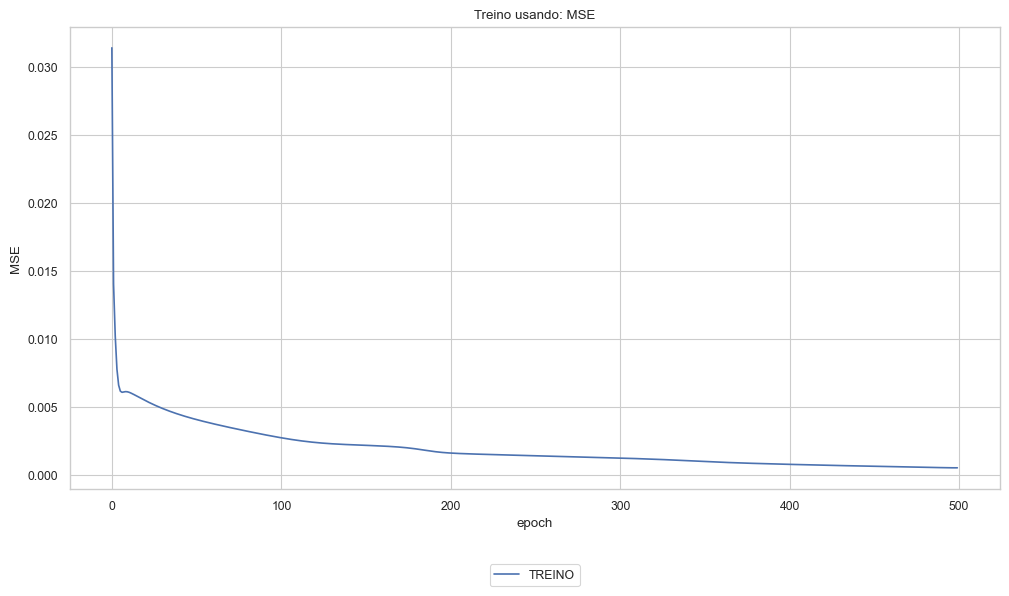

In [31]:
history=np.load('models/' + model_name + '_history_model.npy', allow_pickle='TRUE').item()

sns.set(rc={'figure.figsize':(12, 6)})
sns.set_style('whitegrid')
sns.set_context('paper')

train_metric = history['loss']

if (use_dataset == 'BB'):
    valid_metric = history['val_loss']
    
name_metric = 'mse'

fig = plt.figure()

plt.plot(train_metric, label='TREINO')

if (use_dataset == 'BB'):
    plt.plot(valid_metric, label='VALIDAÇÃO')

plt.ylabel(name_metric.upper())
plt.xlabel('epoch')

if (use_dataset == 'BB'):
    plt.title('Treino vs. Validação usando: ' + name_metric.upper())
else:
    plt.title('Treino usando: ' + name_metric.upper())
    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)

plt.show()

## 7. Testando as previsões

### 7.1 Gerando as previsões com o modelo treinado

In [32]:
test[0:13]

array([[0.68643403],
       [0.78309846],
       [0.8373506 ],
       [0.8397505 ],
       [0.7587261 ],
       [0.6736901 ],
       [0.6015568 ],
       [0.655679  ],
       [0.6622956 ],
       [0.62489414],
       [0.69735146],
       [0.6752989 ],
       [0.698894  ]], dtype=float32)

In [33]:
x_test[0:1]

array([[[0.68643403],
        [0.78309846],
        [0.8373506 ],
        [0.8397505 ],
        [0.7587261 ],
        [0.6736901 ],
        [0.6015568 ],
        [0.655679  ],
        [0.6622956 ],
        [0.62489414],
        [0.69735146],
        [0.6752989 ]]], dtype=float32)

In [34]:
y_test[0:1]

array([[[0.698894]]], dtype=float32)

In [35]:
if (use_dataset == 'AP'):
    #AIR PASSENGER
    #pega os dados reais e volta para a escala original - air passenger
    y_true = scaler.inverse_transform(y_test.reshape(y_test.shape[0],1))
    y_true = inverseVarianceEstabilization(y_true, norm_method).flatten()

In [36]:
if (use_dataset == 'BB'):
    #BANCO DO BRASIL
    #pega os dados reais e volta para a escala original - bbas3
    y_true = scaler.inverse_transform(y_test.reshape(y_test.flatten().shape[0],1))
    y_true = inverseVarianceEstabilization(y_true, norm_method).flatten()

In [37]:
y_true

array([363.00006, 435.00003, 490.9999 , 504.99994, 403.9999 , 358.99994,
       310.00006, 336.99997, 360.00003, 341.9999 , 406.00006, 395.99997,
       419.99997, 471.99997, 548.0001 , 559.00006, 463.     , 407.00006,
       361.99994, 405.     , 417.00003, 390.9999 , 419.     , 460.9999 ,
       471.99997, 535.     , 622.0001 , 606.0001 , 508.0001 , 460.9999 ,
       390.     ], dtype=float32)

In [38]:
y_true.shape

(31,)

In [39]:
#realiza as previsoes do modelo treinado no conjunto de testes e volta para a escala original
y_hat = model_trained.predict(x_test)

1/1 [==============================] - 1s 736ms/step


In [40]:
#pega os dados previstos e coloca na escala original
y_hat = scaler.inverse_transform(y_hat)
y_hat = inverseVarianceEstabilization(y_hat, norm_method).flatten()
y_hat.shape

(31,)

### 7.2 Avaliando as previsões

In [41]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def printRegressionMetrics(y_true, y_pred):
    
    MAPE = mape(y_true, y_pred)
    R2 = metrics.r2_score(y_true, y_pred)
    
    print('MAPE:')
    print(MAPE)
    print('R2:')
    print(R2)

In [42]:
printRegressionMetrics(y_true, y_hat)

MAPE:
8.119425922632217
R2:
0.5730781555175781


In [43]:
if (use_dataset == 'AP'):
    #AIR PASSENGER
    #pega os valores reais anteriores ao ponto de previsao - air passenger
    y_true_trainval = y_trainval.flatten().reshape(len(y_trainval),1)
    y_true_trainval = scaler.inverse_transform(y_true_trainval)
    y_true_trainval = inverseVarianceEstabilization(y_true_trainval, norm_method).flatten()

In [44]:
if (use_dataset == 'BB'):
    #BANCO DO BRASIL
    #pega os valores reais anteriores ao ponto de previsao - bbas3
    y_true_trainval = y_trainval.flatten().reshape(len(y_trainval.flatten()),1)
    y_true_trainval = scaler.inverse_transform(y_true_trainval)
    y_true_trainval = inverseVarianceEstabilization(y_true_trainval, norm_method).flatten()

In [45]:
y_true_trainval.shape

(87,)

In [46]:
#cria um data table com os valores reais e preditos
df_forecast = pd.DataFrame()
df_forecast['y_true'] = np.hstack((y_true_trainval, y_true))
df_forecast['y_hat'] = np.hstack((y_true_trainval, y_hat))

df_forecast.shape

(118, 2)

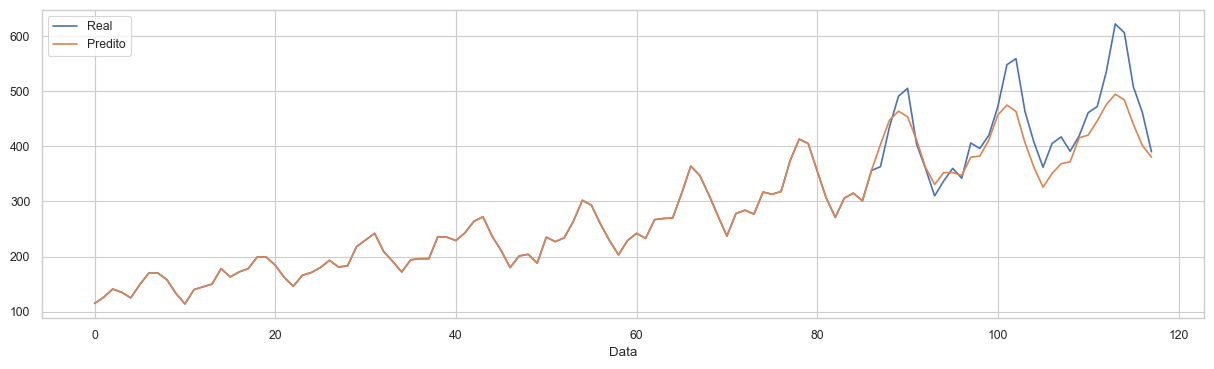

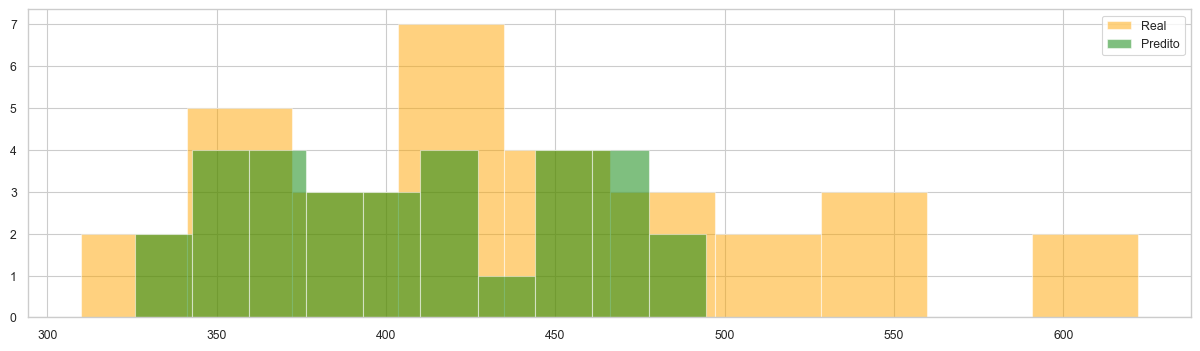

In [47]:
sns.set(rc={'figure.figsize':(15, 4)})
sns.set_style('whitegrid')
sns.set_context('paper')

ax = df_forecast.plot(x_compat=True, style='-')
ax.set_xlabel("Data")
ax.legend(["Real", "Predito"])

plt.grid(True)

plt.show()

plt.close()

sns.set(rc={'figure.figsize':(12, 6)})
sns.set_style('whitegrid')
sns.set_context('paper')

plt.figure(figsize=(15, 4))
plt.hist(y_true, bins=10, color='orange', alpha=0.5, label='Real')
plt.hist(y_hat, bins=10, color='green', alpha=0.5, label='Predito')
plt.legend()

plt.show()

plt.close()

In [48]:
#toca um som para avisar que terminou de executar
pygame.mixer.init()
arquivo_mp3 = 'support_files/mario_coin.mp3'
pygame.mixer.music.load(arquivo_mp3)
pygame.mixer.music.play()

while pygame.mixer.music.get_busy():
    continue
    
print('Sucesso!')

Sucesso!
